
 FAKE NEWS DETECTION


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

READ DATASETS

In [38]:
fake = pd.read_csv('/content/finalfake.csv', encoding='latin-1')
true = pd.read_csv('/content/truefinal.csv', encoding='latin-1')

In [39]:
fake.shape

(390, 4)

In [40]:
true.shape

(391, 4)

DATA CLEANING PREPARATION

In [41]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [42]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(781, 5)

In [43]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [44]:
# Check the data
data.head()

,title,text,subject,date,target
0,The Worst Possible Person Just Won Alabamas R...,Alabama s Republican runoff election for Jeff ...,News,26-Sep-17,fake
1,CNN BLISTERS Trump After He Attacks Them For B...,One of Donald Trump s favorite punching bags i...,News,25-Nov-17,fake
2,Factbox - The four men charged in U.S. probe o...,(The Dec. 1 story was refiled to correct Gate...,politicsNews,01-Dec-17,true
3,Virginia officials postpone lottery drawing to...,(Reuters) - A lottery drawing to settle a tied...,politicsNews,27-Dec-17,true
4,Trump's eldest son testifies to Senate committ...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,13-Dec-17,true


In [45]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,The Worst Possible Person Just Won Alabamas R...,Alabama s Republican runoff election for Jeff ...,News,fake
1,CNN BLISTERS Trump After He Attacks Them For B...,One of Donald Trump s favorite punching bags i...,News,fake
2,Factbox - The four men charged in U.S. probe o...,(The Dec. 1 story was refiled to correct Gate...,politicsNews,true
3,Virginia officials postpone lottery drawing to...,(Reuters) - A lottery drawing to settle a tied...,politicsNews,true
4,Trump's eldest son testifies to Senate committ...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true


In [46]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Alabama s Republican runoff election for Jeff ...,News,fake
1,One of Donald Trump s favorite punching bags i...,News,fake
2,(The Dec. 1 story was refiled to correct Gate...,politicsNews,true
3,(Reuters) - A lottery drawing to settle a tied...,politicsNews,true
4,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true


In [47]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,alabama s republican runoff election for jeff ...,News,fake
1,one of donald trump s favorite punching bags i...,News,fake
2,(the dec. 1 story was refiled to correct gate...,politicsNews,true
3,(reuters) - a lottery drawing to settle a tied...,politicsNews,true
4,washington (reuters) - u.s. president donald t...,politicsNews,true


In [48]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [49]:
# Check
data.head()

,text,subject,target
0,alabama s republican runoff election for jeff ...,News,fake
1,one of donald trump s favorite punching bags i...,News,fake
2,the dec 1 story was refiled to correct gates...,politicsNews,true
3,reuters a lottery drawing to settle a tied vi...,politicsNews,true
4,washington reuters us president donald trump...,politicsNews,true


In [50]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [51]:
data.head()

,text,subject,target
0,alabama republican runoff election jeff sessio...,News,fake
1,one donald trump favorite punching bags cnn ev...,News,fake
2,dec 1 story refiled correct gates first name ...,politicsNews,true
3,reuters lottery drawing settle tied virginia l...,politicsNews,true
4,washington reuters us president donald trumps...,politicsNews,true


BASIC DATA EXPLORATION

subject
News            390
politicsNews    391
Name: text, dtype: int64


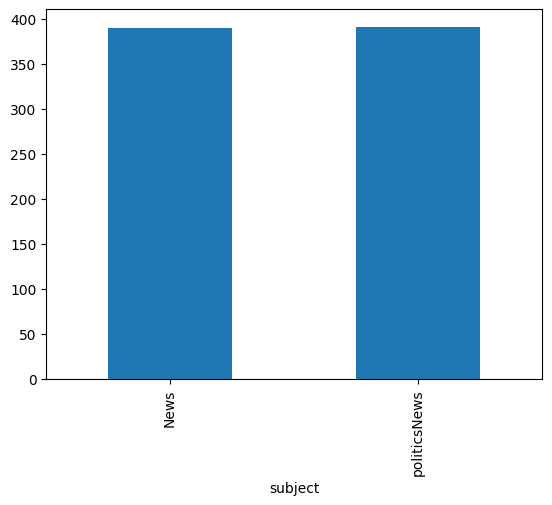

In [52]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    390
true    391
Name: text, dtype: int64


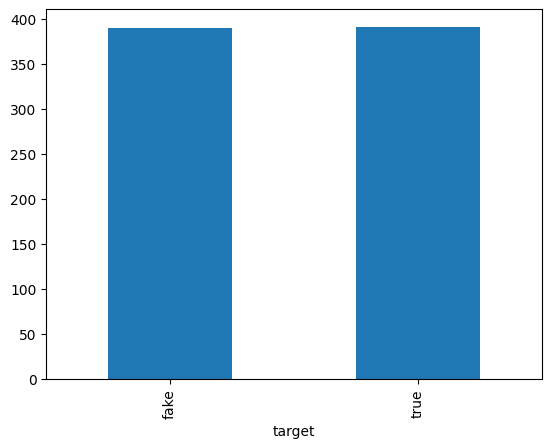

In [53]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

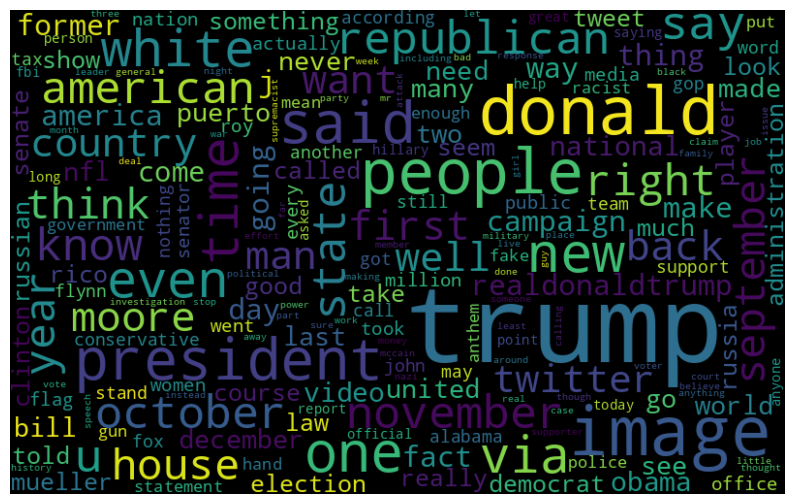

In [54]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

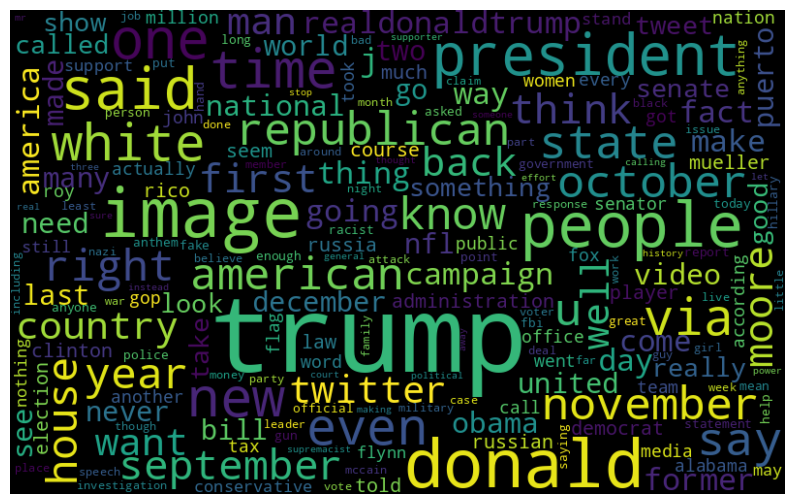

In [55]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [56]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

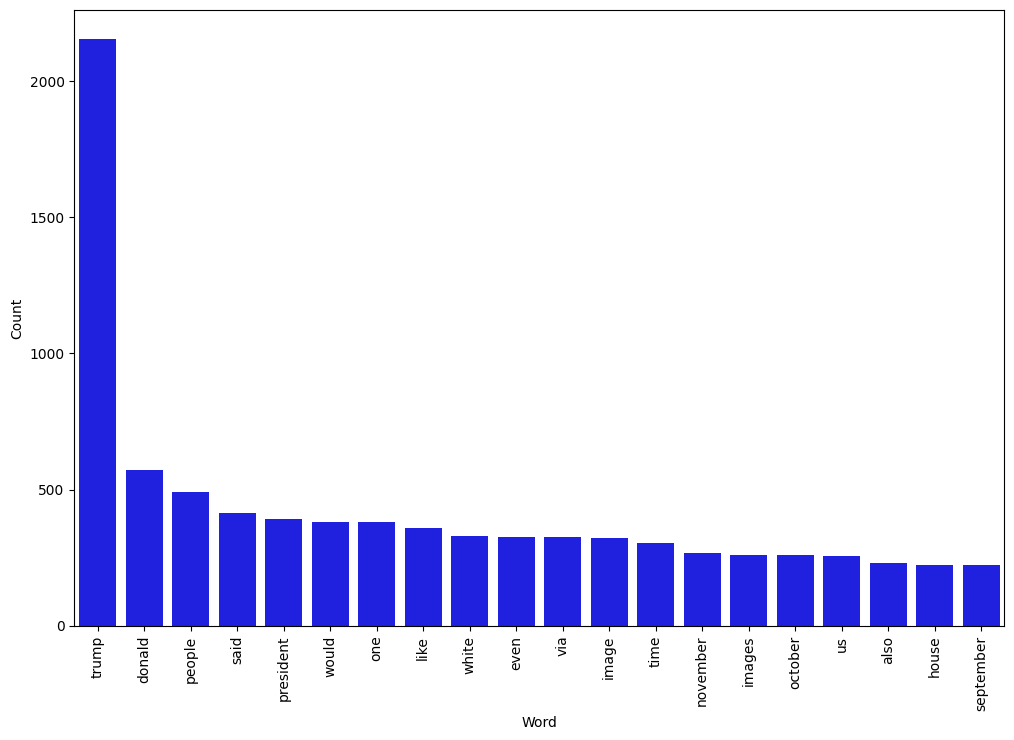

In [57]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


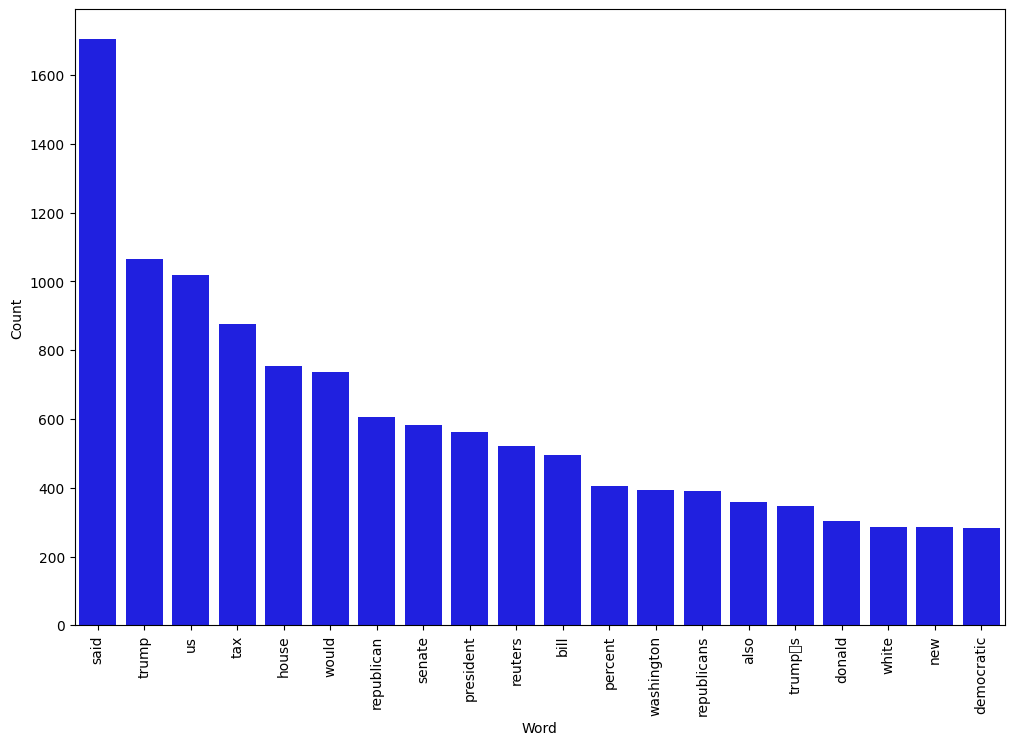

In [58]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

MODELLING

In [59]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

PREPARING DATA

In [60]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

NAIVE BAYES

In [61]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 94.9%


Confusion matrix, without normalization


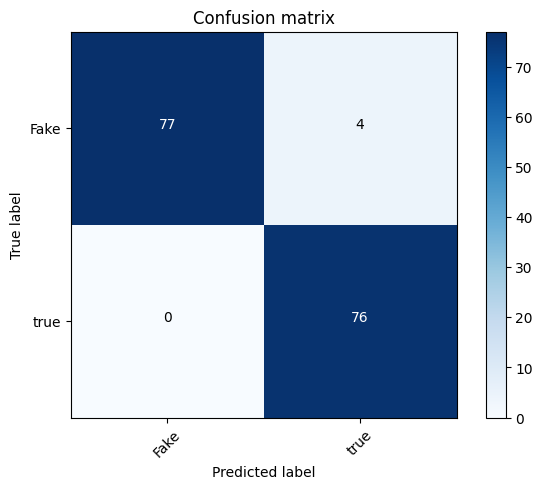

In [65]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'true'])

LOGISTIC REGRESSION

In [63]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 97.45%


Confusion matrix, without normalization


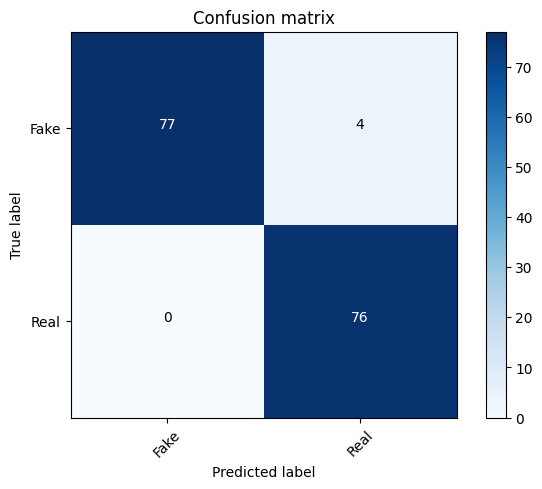

In [64]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

DECISION TREE

In [66]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 100.0%


Confusion matrix, without normalization


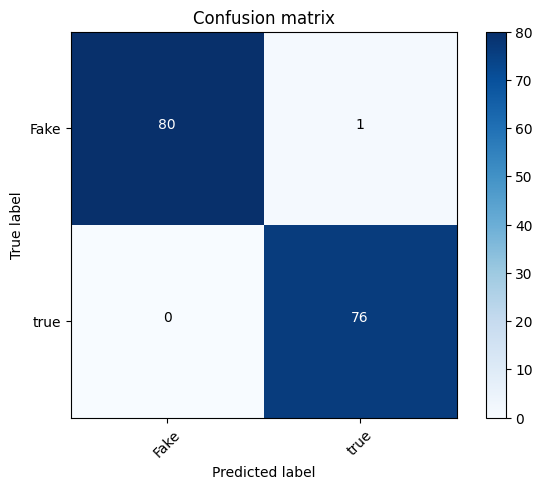

In [69]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'true'])

RANDOM FOREST

In [68]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.36%


Confusion matrix, without normalization


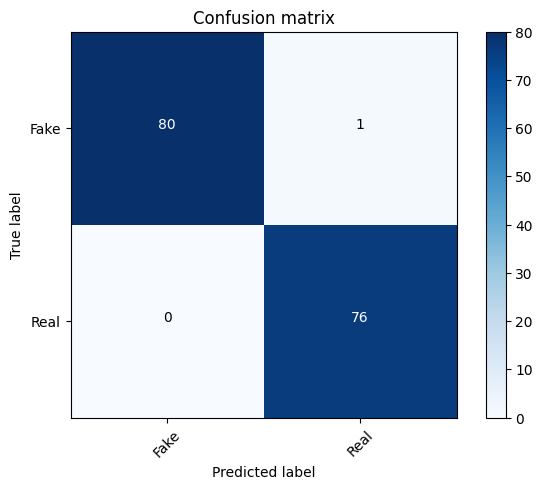

In [70]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

**SVM**

In [71]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.73%


Confusion matrix, without normalization


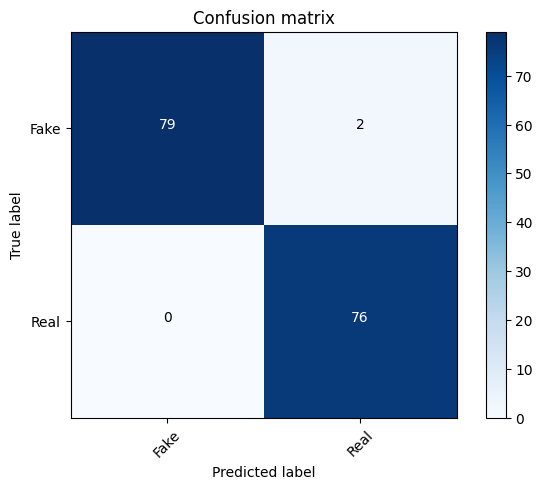

In [72]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

COMPARING DIFFERENT MODELS

([<matplotlib.axis.YTick at 0x789a3c86aec0>,
 [Text(0, 91, '91'),
  Text(0, 92, '92'),
  Text(0, 93, '93'),
  Text(0, 94, '94'),
  Text(0, 95, '95'),
  Text(0, 96, '96'),
  Text(0, 97, '97'),
  Text(0, 98, '98'),
  Text(0, 99, '99'),
  Text(0, 100, '100')])

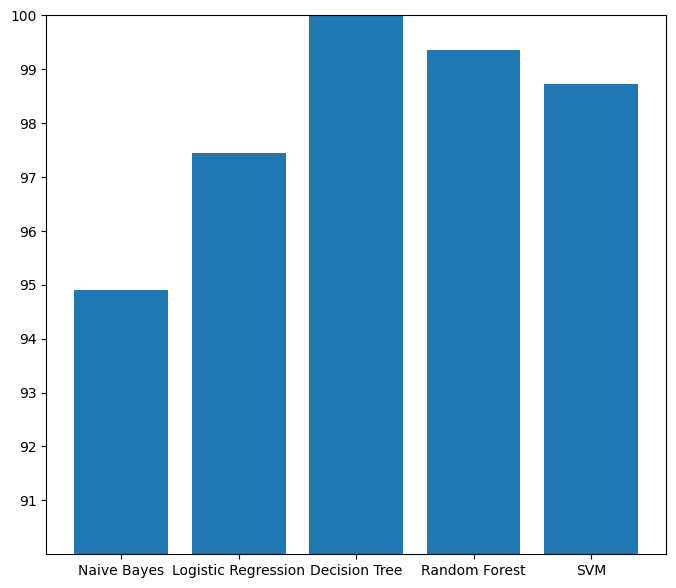

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))